# Workflow for assessing panel measurements in Lake George field data

In [1]:
import csv, glob, sys, os, re
from os import listdir
import numpy as np
import pandas as pd

#%pylab notebook
import datacube
from datetime import datetime, timedelta
import pyproj
from pandas import Series

#
# dc will be used later on when comparing with satellite data:
#
#dc = datacube.Datacube(app='nbart-fieldsites')

In [2]:
#
# Set up input and output directories etc.
#
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
output = indir+'OUTPUT/'
field_site = 'Lake George'
panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
in_panel = 'ga_panel1_jan_2018.txt'
suffix = 'asd.rad.txt'

#
# Setup based on Emma's code
#
sat_resp = dict({'lsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'lsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'lsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt'})

# input file
home2 = '/g/data1a/u46/users/aw3463/GuyByrne/in_spectra/gunning/fr/' 
suffix2 = 'asd.ref.sco.txt'

In [3]:
def spec_readin(suffix, home):
    #
    # Initalise 'spectra' list and fill with files that end in 'suffix'
    #
    spectra = []
    for root, dirs, files in sorted(os.walk(home)):
        for file in files:
            if file.endswith(suffix):
                spectra.append(file)
    spectra = sorted(spectra)
    
    #
    # create list input files - pandas column names
    #
    col_nams = []
    for root, dirs, files in os.walk(home):
        for file in files:
            if file.endswith(suffix):
                tmp = file[:-12] 
                col_nams.append(tmp)
    col_nams = sorted(col_nams)
    
    #
    # Loop over the number of spectra and read in spectral data 
    # into a table 'df'
    #
    count = len(spectra) - 1
    for i in range (0, len(spectra)):
        infile = spectra[i]
        if i == 0: 
            df = pd.read_csv(home + infile, skiprows=38, delim_whitespace=True) 
        else:
            tmpDF = pd.read_csv(home + infile, skiprows=38, delim_whitespace=True)
            df = df.merge(tmpDF)   

    return df

In [4]:
def k_factor(panel_dir, in_panel):
    #
    # Read in k-factor from csv file and add 'wavelength' label
    #
    k_f = pd.read_csv(panel_dir + in_panel, skiprows=5, delim_whitespace=True)
    # Set index to wavelength
    k_f.set_index("Wavelength", inplace = True) 
    
    return k_f


In [10]:
def panel_no_mean(home, name):
    df = spec_readin(suffix, home)
    #
    # Identify those readings that are with the panel, rather than ground 
    # reflectance. This is done by assuing the first wavelength value is 
    # greater than 0.1.
    #
    panels = []
    for column in df.columns[1:]:  # skips the first column
        if (df[column].iloc[1] > 0.1):
            panels.append(column)
    
    #
    # For all panel readings, make an average.
    #
    
    new = df.filter(panels, axis = 1)
    
    xbar = new.mean(axis=1)
    # single column of wavelengths
    waves = df['Wavelength']
    xbar.columns = ['xbar'] 
    result = pd.concat([waves, xbar], axis = 1)
    # Set the df index to wavelenth
    result.set_index("Wavelength", inplace = True) 
    
    prepans = new.copy()
    prepans_result = pd.concat([waves, prepans], axis=1)
    prepans_result.set_index("Wavelength", inplace=True)
    medpans = prepans_result.median(axis=1)
    pans_result = prepans_result.div(medpans, axis=0)
    
    return waves, df, result, panels, pans_result.rename({0: name}, axis=1)

<IPython.core.display.Javascript object>


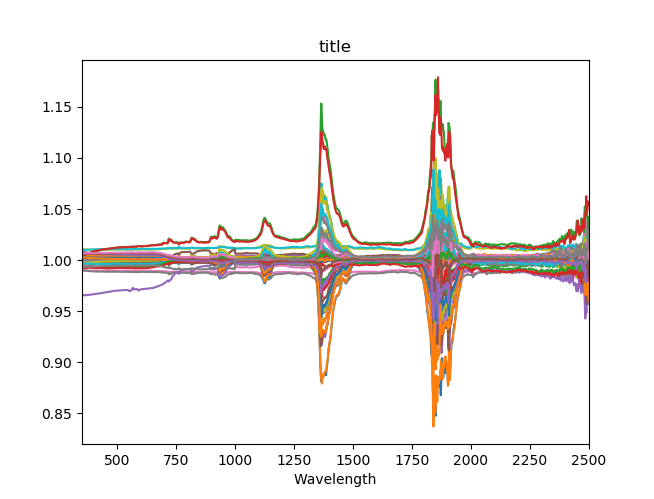

            llg_l100000.asd.rad  llg_l100001.asd.rad  llg_l100034.asd.rad  \
Wavelength                                                                  
350                    1.001791             1.001668             0.999690   
351                    1.001739             1.001741             0.999636   
352                    1.001882             1.001672             0.999665   
353                    1.001926             1.001674             0.999492   
354                    1.002002             1.001803             0.999348   
355                    1.002220             1.001991             0.999426   
356                    1.002177             1.001996             0.999215   
357                    1.001893             1.001840             0.999203   
358                    1.001664             1.001632             0.999242   
359                    1.001775             1.001520             0.999050   
360                    1.002090             1.001660             0.998930   

In [12]:
%matplotlib notebook
#dataframes = []
#home2 = indir+'line'+str(8)+'/'
#waves, df, result, panels, pans_result = panel_mean(home2)
    
#jstest = pans_result.copy()
#dataframes.append(panels)
#jstest = pd.concat(dataframes, axis=1)
#print(jstest, df)
#mean_panel = ind_jstest.mean(axis=1)
#divr = mean_panel.div(median_panel, axis=0)
#norm_med = ind_jstest.div(median_panel, axis=0)

dataframes = []

for li in range(1, len(glob.glob(indir+'line*'))):
    home2 = indir+'line'+str(li)+'/'
    waves, df, result, panels, temp = panel_no_mean(home2, li)
    
    dataframes.append(temp)

jstest = pd.concat(dataframes, axis=1)
jstest[1:2500].plot(title = "title", xlim=(350,2500), legend=False)